# 데이터셋 다운로드

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'oreocube' # username
os.environ['KAGGLE_KEY'] = '6eccd7011bed88a9e3cdc213d8761acb' # key

In [ ]:
!kaggle datasets download -d datamunge/sign-language-mnist
!unzip sign-language-mnist.zip

sign-language-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sign-language-mnist.zip
replace amer_sign2.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace amer_sign3.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 패키지 임포트

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 데이터셋 로드

In [ ]:
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

# 라벨 분포 확인

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


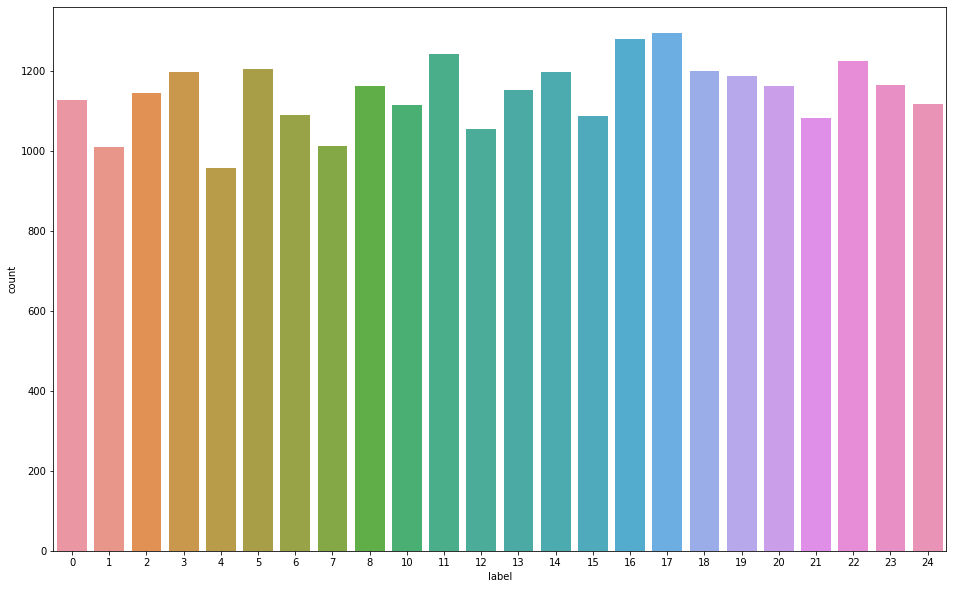

In [ ]:
plt.figure(figsize=(16, 10))
sns.countplot(train_df['label'])
plt.show()

# 전처리
## 입력과 출력 나누기

In [ ]:
train_df = train_df.astype(np.float32)
x_train = train_df.drop(columns=['label'], axis=1).values
x_train = x_train.reshape((-1, 28, 28, 1)) # -1: 배치사이즈, 28 : 데이터셋 크기, 1: gray
y_train = train_df[['label']].values

test_df = test_df.astype(np.float32)
x_test = test_df.drop(columns=['label'], axis=1).values
x_test = x_test.reshape((-1, 28, 28, 1))
y_test = test_df[['label']].values

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(27455, 28, 28, 1) (27455, 1)
(7172, 28, 28, 1) (7172, 1)


## 데이터 미리보기

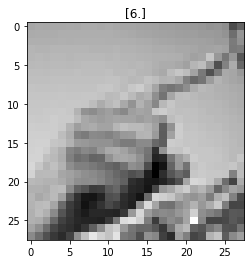

In [ ]:
index = 1
plt.title(str(y_train[index]))
plt.imshow(x_train[index].reshape((28, 28)), cmap='gray')
plt.show()

## one-hot 인코딩

In [ ]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray() # y data 만 one-hot 인코딩
y_test = encoder.fit_transform(y_test).toarray()

## 일반화

In [ ]:
train_image_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1, # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1 # 랜덤하게 이미지를 수직으로 이동 (%)
)
train_datagen = train_image_datagen.flow(
  x=x_train,
  y=y_train,
  batch_size=256,
  shuffle=True
)
test_image_datagen = ImageDataGenerator(
  rescale=1./255
)
test_datagen = test_image_datagen.flow(
  x=x_test,
  y=y_test,
  batch_size=256,
  shuffle=False
)

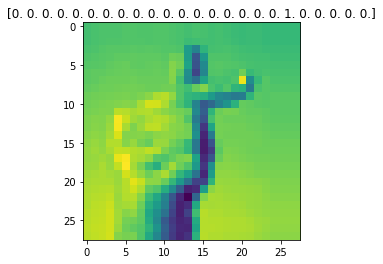

In [ ]:
index = 1
preview_img = train_datagen.__getitem__(0)[0][index]
preview_label = train_datagen.__getitem__(0)[1][index]

plt.imshow(preview_img.reshape((28, 28)))
plt.title(str(preview_label))
plt.show()

# 네트워크 구성하기

In [ ]:
input = Input(shape=(28, 28, 1))

# 필터 갯수 32, 필터 크기 3*3, 스트라이드 1, 패딩 input=output, 활성화함수 relu
hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden) # 차원을 반으로 줄임

# 필터 갯수 64
hidden = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

# 필터 갯수 32
hidden = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(hidden)
hidden = MaxPooling2D(pool_size=2, strides=2)(hidden)

# 일차원으로 펼처야 dense-layer와 연산 가능
hidden = Flatten()(hidden)

hidden = Dense(512, activation='relu')(hidden)

# 오버피팅을 피하기 위해 드랍아웃. 30% 노드를 랜덤으로 탈락시킴.
hidden = Dropout(rate=0.3)(hidden)

# 알파벳 24개 예측하는 fully connected dense layer에 넣어줌
output = Dense(24, activation='softmax')(hidden)

model = Model(inputs=input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['acc'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 32)          0   

# 모델 학습시키기

In [ ]:
history = model.fit(
train_datagen,
validation_data=test_datagen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
epochs=20 # epochs 복수형으로 쓰기!
)

Epoch 1/20
108/108 [==============================] - 13s 113ms/step - loss: 2.4740 - acc: 0.2525 - val_loss: 1.3206 - val_acc: 0.6044
Epoch 2/20
108/108 [==============================] - 12s 109ms/step - loss: 1.2394 - acc: 0.6050 - val_loss: 0.6307 - val_acc: 0.7835
Epoch 3/20
108/108 [==============================] - 12s 107ms/step - loss: 0.7387 - acc: 0.7568 - val_loss: 0.3935 - val_acc: 0.8639
Epoch 4/20
108/108 [==============================] - 12s 108ms/step - loss: 0.5180 - acc: 0.8274 - val_loss: 0.2511 - val_acc: 0.9262
Epoch 5/20
108/108 [==============================] - 12s 108ms/step - loss: 0.3889 - acc: 0.8733 - val_loss: 0.1737 - val_acc: 0.9547
Epoch 6/20
108/108 [==============================] - 12s 108ms/step - loss: 0.2830 - acc: 0.9080 - val_loss: 0.1625 - val_acc: 0.9536
Epoch 7/20
108/108 [==============================] - 12s 108ms/step - loss: 0.2292 - acc: 0.9245 - val_loss: 0.1085 - val_acc: 0.9697
Epoch 8/20
108/108 [==============================] - 1

# 학습 결과 그래프

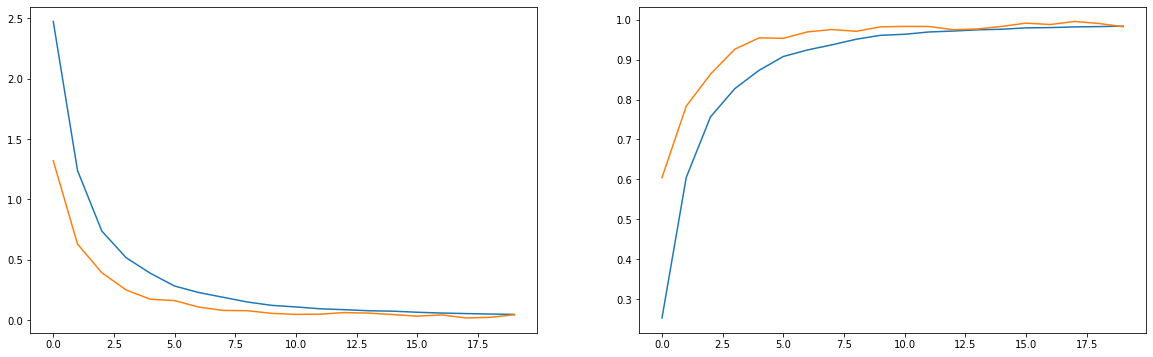

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])